In [ ]:
!pip install apriltag # install python library that detects apriltags

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 5.1 MB/s 
  Created wheel for apriltag: filename=apriltag-0.0.16-cp37-cp37m-linux_x86_64.whl size=562169 sha256=a891b069b5687a4f753ed9d65032fcd90c232967cfe7de6c5c1bd52b0fe07122
  Stored in directory: /root/.cache/pip/wheels/83/29/7f/e1690d95bf4c49d9e767fc1534853e010594256a8a177ac8dd
Successfully built apriltag


## PARTIE 1 : CRÉATION AUTOMATIQUE DE DONNÉES D’ENTRAÎNEMENT

In [ ]:
## This resizing is for part 2 
p = "/content/drive/MyDrive/sysnav/images/"

from tqdm import tqdm
import os
from PIL import Image

# dsize
dsize = (736, 544)


for im in tqdm(os.listdir(p)):
  img = cv2.imread(p+im)
  # resize image for uney
  output = cv2.resize(img, dsize)
  cv2.imwrite(p+im,output) 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import apriltag # documentation : https://pyimagesearch.com/2020/11/02/apriltag-with-python/

def get_corners(r):
  # extract the bounding box (x, y)-coordinates for the AprilTag
  # and convert each of the (x, y)-coordinate pairs to integers
  (ptA, ptB, ptC, ptD) = r.corners
  
  ptB = (int(ptB[0]), int(ptB[1]))
  ptC = (int(ptC[0]), int(ptC[1]))
  ptD = (int(ptD[0]), int(ptD[1]))
  ptA = (int(ptA[0]), int(ptA[1]))
  
  u_l_x, u_l_y = ptA
  u_r_x, u_r_y = ptB 
  l_r_x, l_r_y = ptC
  l_l_x, l_l_y = ptD

  return u_l_x, u_l_y, u_r_x, u_r_y, l_r_x, l_r_y, l_l_x, l_l_y

options = apriltag.DetectorOptions(families="tag36h11")
detector = apriltag.Detector(options)


path_to_images = "/content/drive/MyDrive/sysnav/images/"
data=[]

print("[INFO] loading images and detecting AprilTags...")
for img in tqdm(os.listdir(path_to_images)):
  if '(1)' in img:
    continue
  try:
    image = cv2.imread(path_to_images+img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    results = detector.detect(gray)
  except:
    continue
  if len(results)==0:
    # no tag was detected here
    continue
  r = results[0]
  u_l_x, u_l_y, u_r_x, u_r_y, l_r_x, l_r_y, l_l_x, l_l_y = get_corners(r)
  data.append({
      "image_id":int(img.split('_')[-1].split('.')[0]),
      "upper_left_x":u_l_x,
      "upper_left_y":u_l_y,
      "upper_right_x":u_r_x,
      "upper_right_y":u_r_y,
      "lower_right_x":l_r_x, 
      "lower_right_y":l_r_y, 
      "lower_left_x":l_l_x,
      "lower_left_y":l_l_y
      })

print("[INFO] {} total AprilTags detected".format(len(data)))
df = pd.DataFrame(data)
df.head()

[INFO] loading images and detecting AprilTags...


100%|██████████| 3788/3788 [01:53<00:00, 33.49it/s]

[INFO] 1780 total AprilTags detected


,image_id,upper_left_x,upper_left_y,upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y
0,2739,290,254,374,264,369,418,286,406
1,2748,318,251,380,264,373,379,311,363
2,2762,440,267,482,285,476,375,433,356
3,2743,309,254,381,264,376,398,304,384
4,2740,295,256,376,266,370,414,290,402


In [ ]:
df.to_csv("train.csv",index=False) # default sep is ","

## PARTIE 2 : DÉTECTEUR DE TAG PAR APPRENTISSAGE PROFOND

In [ ]:
df

,image_id,upper_left_x,upper_left_y,upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y
0,2739,290,254,374,264,369,418,286,406
1,2748,318,251,380,264,373,379,311,363
2,2762,440,267,482,285,476,375,433,356
3,2743,309,254,381,264,376,398,304,384
4,2740,295,256,376,266,370,414,290,402
...,...,...,...,...,...,...,...,...,...
1775,646,241,338,284,343,289,427,245,432
1776,677,383,282,408,283,412,336,387,338
1777,640,295,331,336,334,342,419,301,425
1778,658,186,340,225,342,229,417,189,421


In [ ]:
!mkdir /content/drive/MyDrive/sysnav/masks

In [ ]:
def make_mask(fname,pts):
  mask = np.zeros((544, 736), dtype="uint8")
  cv2.fillPoly(mask, pts=np.int32([pts]), color=(255,255,255))
  np.save(fname+".npy",mask)
  return 


In [39]:

df = pd.read_csv("/content/drive/MyDrive/sysnav/train.csv")

In [ ]:

for im_name in tqdm(os.listdir("/content/drive/MyDrive/sysnav/images/")):
  if '(1)' in im_name:
    continue
  id_ = int(im_name.split('_')[-1].split('.')[0])
  if id_ in df.image_id.tolist():
    ptA0,ptA1,ptB0,ptB1,ptC0,ptC1,ptD0,ptD1 = df.loc[df.image_id==id_].values.tolist()[0][1:]
    ptA = (ptA0,ptA1)
    ptB = (ptB0,ptB1)
    ptC = (ptC0,ptC1)
    ptD = (ptD0,ptD1)
    pts = np.array([ptA, ptB, ptC, ptD])
    fname = "/content/drive/MyDrive/sysnav/masks/"+"mask_"+im_name.split('_')[-1].split('.')[0]
    make_mask(fname,pts)
  else:
    mask = np.zeros((544, 736), dtype="uint8")
    fname = "/content/drive/MyDrive/sysnav/masks/"+"mask_"+im_name.split('_')[-1].split('.')[0]
    np.save(fname+".npy",mask)


In [18]:
import numpy as np
import pandas as pd
import torch 
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from skimage.io import imread
import scipy as sp
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image 
import math
import sys
import random
import cv2
import gc
import os
from tqdm import tqdm
from datetime import datetime
import json

import warnings
warnings.filterwarnings("ignore")

In [4]:
path_train = "/content/drive/MyDrive/sysnav/images/"
image_ids = os.listdir(path_train)
len(image_ids)

3782

In [ ]:
## DOCUMENTATION : https://www.kaggle.com/code/alexj21/pytorch-eda-unet-from-scratch-finetuning/notebook

In [5]:
def masks_as_image(fname):
    # Take the individual ship masks and create a single mask array for all ships
    M=np.load('/content/drive/MyDrive/sysnav/masks/'+fname)
    return np.expand_dims(M, -1)
    
class ApriltagDataset(Dataset):
    def __init__(self, image_ids, transform=None, mode='train'):
        self.image_ids =  image_ids
        self.image_masks = [m.replace('img','mask').split('.')[0]+'.npy' for m in self.image_ids]
        self.transform = transform
        self.mode = mode
        self.img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # use mean and std from ImageNet 

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if (self.mode == 'train') | (self.mode == 'validation'):
            rgb_path = os.path.join(path_train, img_file_name)
        img = cv2.imread(rgb_path) #imread()
        mask = masks_as_image(self.image_masks[idx])
        
        if self.transform is not None: 
            img, mask = self.transform(img, mask)
            
        if (self.mode == 'train') | (self.mode == 'validation'):
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()  
        

In [6]:
# Data augmentation - didn't use it for now
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask

class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask


class Rotate:
    def __init__(self, limit=90, prob=0.5):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return img, mask

class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask

class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask

In [7]:
# Metrics

def compute_metrics(pred, true, batch_size=16, threshold=0.5):
    pred = pred.view(batch_size, -1)
    true = true.view(batch_size, -1)
    
    pred = (pred > threshold).float()
    true = (true > threshold).float()
    
    pred_sum = pred.sum(-1)
    true_sum = true.sum(-1)
    
    neg_index = torch.nonzero(true_sum == 0)
    pos_index = torch.nonzero(true_sum >= 1)
    
    dice_neg = (pred_sum == 0).float()
    dice_pos = 2 * ((pred * true).sum(-1)) / ((pred + true).sum(-1))
    
    dice_neg = dice_neg[neg_index]
    dice_pos = dice_pos[pos_index]
    
    dice = torch.cat([dice_pos, dice_neg])
    jaccard = dice / (2 - dice)
    
    return dice, jaccard
    
class metrics:
    def __init__(self, batch_size=16, threshold=0.5):
        self.threshold = threshold
        self.batchsize = batch_size
        self.dice = []
        self.jaccard = []
    def collect(self, pred, true):
        pred = torch.sigmoid(pred)
        dice, jaccard = compute_metrics(pred, true, batch_size=self.batchsize, threshold=self.threshold)
        self.dice.extend(dice)
        self.jaccard.extend(jaccard)

        self.dice = [e.item() if type(e)!=float else e for e in self.dice]
        self.jaccard = [e.item() if type(e)!=float else e for e in self.jaccard]
    def get(self):
        dice = np.nanmean(self.dice)
        jaccard = np.nanmean(self.jaccard)
        return dice, jaccard

In [8]:
# Losses

class BCEJaccardWithLogitsLoss(nn.Module):
    def __init__(self, jaccard_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight
        self.smooth = smooth

    def forward(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        if self.jaccard_weight:
            targets = (targets == 1.0).float()
            targets = targets.view(-1)
            outputs = torch.sigmoid(outputs)
            outputs = outputs.view(-1)

            intersection = (targets * outputs).sum()
            union = outputs.sum() + targets.sum() - intersection

            loss -= self.jaccard_weight * torch.log((intersection + self.smooth ) / (union + self.smooth )) # try with 1-dice
        return loss

class BCEDiceWithLogitsLoss(nn.Module):
    def __init__(self, dice_weight=1, smooth=1):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.smooth = smooth
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = F.sigmoid(outputs)
        outputs = outputs.view(-1)

        intersection = (outputs * targets).sum()
        dice = 2.0 * (intersection + self.smooth)  / (targets.sum() + outputs.sum() + self.smooth)
        
        loss -= self.dice_weight * torch.log(dice) # try with 1- dice

        return loss
    
class FocalWithLogitsLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.gamma = gamma
        
    def __call__(self, outputs, targets):
        if outputs.size() != targets.size():
            raise ValueError("size mismatch, {} != {}".format(outputs.size(), targets.size()))
            
        loss = self.bce(outputs, targets)

        targets = (targets == 1.0).float()
        targets = targets.view(-1)
        outputs = torch.sigmoid(outputs)
        outputs = outputs.view(-1)
        outputs = torch.where(targets == 1, outputs, 1 - outputs)

        focal = self.alpha * (1 - outputs) ** (self.gamma)
        loss *= focal.mean()

        return loss

def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [9]:
# Models

"""Improved U-Net""" 
# Implementation from https://github.com/timctho/unet-pytorch/
class IUNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(IUNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class IUNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(IUNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class IUNet(torch.nn.Module):
    def __init__(self):
        super(IUNet, self).__init__()

        self.down_block1 = IUNet_down_block(3, 16, False)
        self.down_block2 = IUNet_down_block(16, 32, True)
        self.down_block3 = IUNet_down_block(32, 64, True)
        self.down_block4 = IUNet_down_block(64, 128, True)
        self.down_block5 = IUNet_down_block(128, 256, True)
        self.down_block6 = IUNet_down_block(256, 512, True)
        self.down_block7 = IUNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = IUNet_up_block(512, 1024, 512)
        self.up_block2 = IUNet_up_block(256, 512, 256)
        self.up_block3 = IUNet_up_block(128, 256, 128)
        self.up_block4 = IUNet_up_block(64, 128, 64)
        self.up_block5 = IUNet_up_block(32, 64, 32)
        self.up_block6 = IUNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x
        
        
"""Original U-Net"""
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 64, False)
        self.down_block2 = UNet_down_block(64, 128, True)
        self.down_block3 = UNet_down_block(128, 256, True)
        self.down_block4 = UNet_down_block(256, 512, True)
        self.down_block5 = UNet_down_block(512, 1024, True)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)

        self.last_conv = torch.nn.Conv2d(64, 1, 1, padding=0)

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        x = self.up_block1(self.x4, self.x5)
        x = self.up_block2(self.x3, x)
        x = self.up_block3(self.x2, x)
        x = self.up_block4(self.x1, x)
        x = self.last_conv(x)
        return x

In [10]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, init_optimizer, train_batch_sz=16, valid_batch_sz=4, n_epochs=1, fold=1):
    
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = init_optimizer(lr)

    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  train_batch_sz)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        valid_metrics = metrics(batch_size=valid_batch_sz)  # for validation
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, targets)
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.item())
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            
            # Validation
            comb_loss_metrics = validation(model, criterion, valid_loader, valid_metrics)
            write_event(log, step, **comb_loss_metrics)

        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return
        
def validation(model: nn.Module, criterion, valid_loader, metrics):
    print("Validation")
    
    losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    for inputs, targets in valid_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        metrics.collect(outputs.detach().cpu(), targets.detach().cpu()) # get metrics 
    
    valid_loss = np.mean(losses)  # float
    valid_dice, valid_jaccard = metrics.get() # float

    print('Valid loss: {:.5f}, Jaccard: {:.5f}, Dice: {:.5f}'.format(valid_loss, valid_jaccard, valid_dice))
    comb_loss_metrics = {'valid_loss': valid_loss, 'jaccard': valid_jaccard.item(), 'dice': valid_dice.item()}
    
    return comb_loss_metrics

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

In [11]:



unique_img_ids = image_ids
train_ids, val_ids = train_test_split(unique_img_ids, test_size=0.15, random_state=42)

In [12]:
len(train_ids)+len(val_ids)

3782

In [13]:



def imshow_mask(img, mask):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    
    fig, axs = plt.subplots(1,2, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(mask)
    axs[1].axis('off')
def imshow_gt_out(img, mask_gt, mask_out):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    mask_gt = mask_gt.numpy().transpose((1, 2, 0))
    mask_gt = np.clip(mask_gt, 0, 1)

    mask_out = mask_out.numpy().transpose((1, 2, 0))
    mask_out = np.clip(mask_out, 0, 1)

    fig, axs = plt.subplots(1,3, figsize=(10,30))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Input image")
    axs[1].imshow(mask_gt)
    axs[1].axis('off')
    axs[1].set_title("Ground truth")
    axs[2].imshow(mask_out)
    axs[2].axis('off')
    axs[2].set_title("Model output")
    plt.subplots_adjust(wspace=0, hspace=0)

In [14]:
# Booleans
SHOW_PIXELS_DIST = False
SHOW_SHIP_DIAG = False
SHOW_IMG_LOADER = False

# Training variables
BATCH_SZ_TRAIN = 16
BATCH_SZ_VALID = 4
LR = 1e-4
N_EPOCHS = 3

# Define loss function
LOSS = 'BCEWithDigits' # BCEWithDigits | FocalLossWithDigits | BCEDiceWithLogitsLoss | BCEJaccardWithLogitsLoss

# Define model
MODEL_SEG = 'UNET_RESNET34ImgNet' # UNET | IUNET | UNET_RESNET34ImgNet 
FREEZE_RESNET = False   # if UNET_RESNET34ImgNet

# Fetch U-Net with a pre-trained RESNET34 encoder on imagenet
if MODEL_SEG == 'UNET_RESNET34ImgNet':
    !pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.
    import segmentation_models_pytorch as smp

In [16]:


# Initialize dataset
train_dataset = ApriltagDataset(train_ids, mode='train')
val_dataset = ApriltagDataset(val_ids, mode='validation')

print('Train samples : %d | Validation samples : %d' % (len(train_dataset), len(val_dataset)))

# Get loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SZ_TRAIN, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SZ_VALID, shuffle=True, num_workers=0)

if SHOW_IMG_LOADER == True:
    # Display some images from loader
    images, mask = next(iter(train_loader))
    imshow_mask(torchvision.utils.make_grid(images, nrow=1), torchvision.utils.make_grid(mask, nrow=1))
    plt.show()
    
# Train
run_id = 1

if MODEL_SEG == 'IUNET':
    model = IUNet()
elif MODEL_SEG == 'UNET':
    model = UNet()
elif MODEL_SEG == 'UNET_RESNET34ImgNet':
    model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
    if FREEZE_RESNET == True:
        for name, p in model.named_parameters():
            if "encoder" in name:
                p.requires_grad = False
else:
    raise NameError("model not supported")
    
if LOSS == 'BCEWithDigits':
    criterion = nn.BCEWithLogitsLoss()
elif LOSS == 'FocalLossWithDigits':
    criterion = MixedLoss(10, 2)
elif LOSS == 'BCEDiceWithLogitsLoss':
    criterion = BCEDiceWithLogitsLoss()
elif LOSS == 'BCEJaccardWithLogitsLoss':
    criterion = BCEJaccardWithLogitsLoss()
else:
    raise NameError("loss not supported")

train(init_optimizer=lambda lr: optim.Adam(model.parameters(), lr=lr),
        lr = LR,
        n_epochs = N_EPOCHS,
        model=model,
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=val_loader,
        train_batch_sz= BATCH_SZ_TRAIN,
        valid_batch_sz=BATCH_SZ_VALID,
        fold=run_id
        )



Train samples : 3214 | Validation samples : 568


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Epoch 1, lr 0.0001: 100%|█████████▉| 3214/3216 [27:42<00:01,  1.93it/s, loss=-82.85202]


Validation
Valid loss: -85.52402, Jaccard: 0.23871, Dice: 0.29851


Epoch 2, lr 0.0001: 100%|█████████▉| 3214/3216 [05:12<00:00, 10.29it/s, loss=-137.39377]


Validation
Valid loss: -170.27172, Jaccard: 0.29321, Dice: 0.35722


Epoch 3, lr 0.0001: 100%|█████████▉| 3214/3216 [05:09<00:00, 10.37it/s, loss=-189.40233]


Validation
Valid loss: -205.41261, Jaccard: 0.35605, Dice: 0.41699


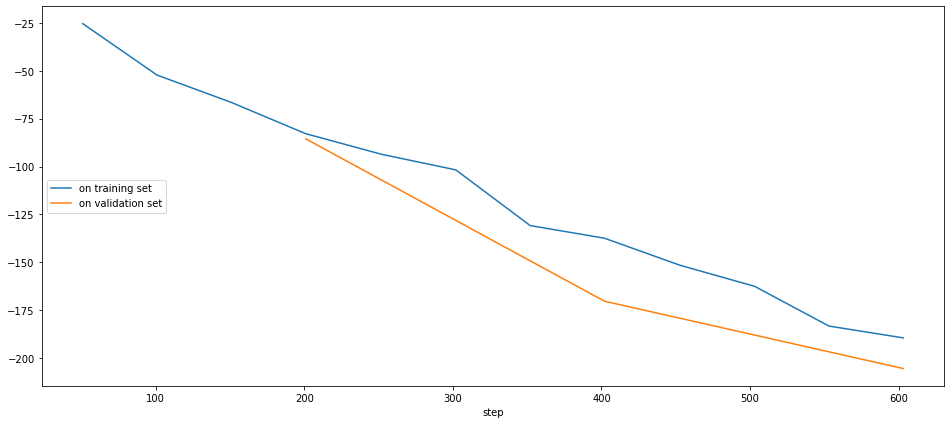

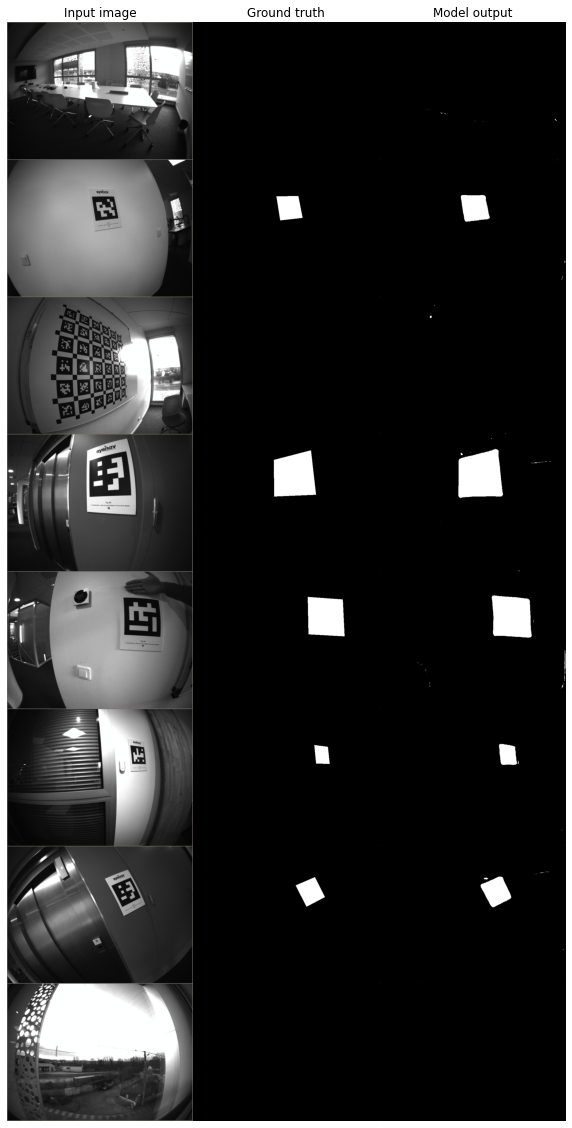

In [23]:

# Plot losses
log_file = 'train_{fold}.log'.format(fold=run_id)
logs = pd.read_json(log_file, lines=True)

plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(logs.step[logs.loss.notnull()],
            logs.loss[logs.loss.notnull()],
            label="on training set")

plt.plot(logs.step[logs.valid_loss.notnull()],
            logs.valid_loss[logs.valid_loss.notnull()],
            label = "on validation set")
         
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show();


# Model inference
model_path ='model_{fold}.pt'.format(fold=run_id)
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

val_dataset = ApriltagDataset(val_ids)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

# Display some images from loader
images, gt = next(iter(val_loader))
gt = gt.data.cpu()
images = images.to(device)
out = model.forward(images)
out = ((out > 0).float()) * 255
images = images.data.cpu()
out = out.data.cpu()
imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
plt.show()

In [24]:
def maxContours(contours):
  A=[]
  for i in range(len(contours)):
    rect = cv2.minAreaRect(contours[i]) # basically you can feed this rect into your classifier
    (x,y),(w,h), a = rect
    A.append(w*h)
  idx = np.where(np.array(A)==max(A))[0][0]
  return contours[idx]

def convert_mask_to_coordinates(mask):
  mask_gray = cv2.normalize(src=mask, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  contours,_ = cv2.findContours(mask_gray.copy(), 1, 1) # not copying here will throw an error
  C = maxContours(contours)
  rect = cv2.minAreaRect(C) 
  box = np.int0(cv2.boxPoints(rect))
  u_l_x, u_l_y, u_r_x, u_r_y, l_r_x, l_r_y, l_l_x, l_l_y = box[1,0],box[1,1],box[2,0],box[2,1],box[3,0],box[3,1],box[0,0],box[0,1]
  return u_l_x, u_l_y, u_r_x, u_r_y, l_r_x, l_r_y, l_l_x, l_l_y


In [34]:
pd.DataFrame([convert_mask_to_coordinates(M)])

,0,1,2,3,4,5,6,7
0,694,383,697,383,697,387,694,387


In [36]:
all_dataset = ApriltagDataset(image_ids)
ds_loader = torch.utils.data.DataLoader(all_dataset, batch_size=8, shuffle=False, num_workers=0)

In [37]:
preds=[]
for (images, gt) in tqdm(ds_loader):
  images = images.to(device)
  out = model.forward(images)
  out = ((out > 0).float()) * 255
  out = out.data.cpu()
  for e in out:
    mask = e[0,:,:].numpy()
    preds.append(convert_mask_to_coordinates(mask))

len(preds)

100%|██████████| 473/473 [03:27<00:00,  2.28it/s]


3782

In [42]:
ids = list(map(lambda x: int(x.split('_')[-1].split('.')[0]), image_ids))

In [45]:
detections = pd.DataFrame(preds,columns=['upper_left_x', 'upper_left_y', 'upper_right_x',
       'upper_right_y', 'lower_right_x', 'lower_right_y', 'lower_left_x',
       'lower_left_y'])
detections['image_id'] = ids

cols = ['image_id', 'upper_left_x', 'upper_left_y', 'upper_right_x',
       'upper_right_y', 'lower_right_x', 'lower_right_y', 'lower_left_x',
       'lower_left_y']

detections[cols].to_csv('detection.csv',index=False)
detections[cols].head()

,image_id,upper_left_x,upper_left_y,upper_right_x,upper_right_y,lower_right_x,lower_right_y,lower_left_x,lower_left_y
0,1238,717,428,718,444,715,445,713,429
1,126,0,542,0,542,0,542,0,542
2,668,387,211,392,269,341,273,336,216
3,1576,602,82,602,83,600,83,600,82
4,1210,0,542,0,542,0,542,0,542
